# Point72 Global Futures Analysis

Diego Alvarez <br> diego.alvarez@colorado.edu

# Background

Rather than creating an object and then methods for the object functions will be defined as problems / tasks occur so that the flow of the notebook is easier to follow

# Packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

np.random.seed(123)

# Accessing Data

## Path Management

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
price_path = os.path.join(data_path, "prices.parquet")
price_sample_path = os.path.join(data_path, "prices_samples.parquet")

## Reading in Data

In [3]:
try: df_price = pd.read_parquet(path = price_path, engine = "pyarrow")
except: df_price = pd.read_parquet(path = price_sample_path, engine = "pyarrow") 

# Metadata

Check for duplicates 

In [4]:
def check_duplicates(df: pd.DataFrame):

    df_duplicates = (df.groupby(
        ["contract_name", "local_time"]).
        agg("count").
        reset_index().
        melt(id_vars = ["contract_name", "local_time"]).
        query("value != 1"))

    if len(df_duplicates) == 0: print("No Duplicates Detected")
    else: print("Duplicates Detected")
    
check_duplicates(df_price)

No Duplicates Detected


Look at data count in total with start and stop

In [5]:
def get_count(df: pd.DataFrame):

    display(df[
        ["contract_name", "local_time"]].
        groupby(["contract_name"]).
        agg(["min", "max", "count"])
        ["local_time"])
    
get_count(df_price)

,min,max,count
contract_name,,,
Chicago1,2013-01-01 00:00:00,2022-12-31 18:00:00,1051585
Frankfurt1,2013-01-01 01:00:00,2022-12-31 23:55:00,1051524
London1,2013-01-01 00:00:00,2022-12-31 23:55:00,1051536
NYC1,2013-01-01 00:00:00,2022-12-31 19:00:00,1051597
Tokyo1,2013-01-01 09:00:00,2022-12-31 23:55:00,1051548


Ensuring that there are 250 trading days per each year

In [6]:
def check_open_trade_day(df: pd.DataFrame):

    df_count = (df[
        ["contract_name", "market_day", "local_time"]].
        assign(
            date = lambda x: pd.to_datetime(x.local_time.dt.strftime("%Y-%m-%d")),
            year = lambda x: x.date.dt.year).
        drop(columns = ["local_time"]).
        drop_duplicates().
        groupby(["contract_name", "year", "market_day"]).
        agg("count").
        reset_index().
        query("market_day == 'open' & date != 250"))
    
    if len(df_count) == 0: print("250 trading days present every year of every contract")
    else: print("There are not 250 trading days persent every year of every contract")

check_open_trade_day(df_price)

250 trading days present every year of every contract


# Exploratory Data Analysis

Simply plot the data and account for the various contracts as they get rolled. In this case use close as the price. Due to the computational strain of plotting 5 min bars for 10yrs the data will be resampled with the first price of each day

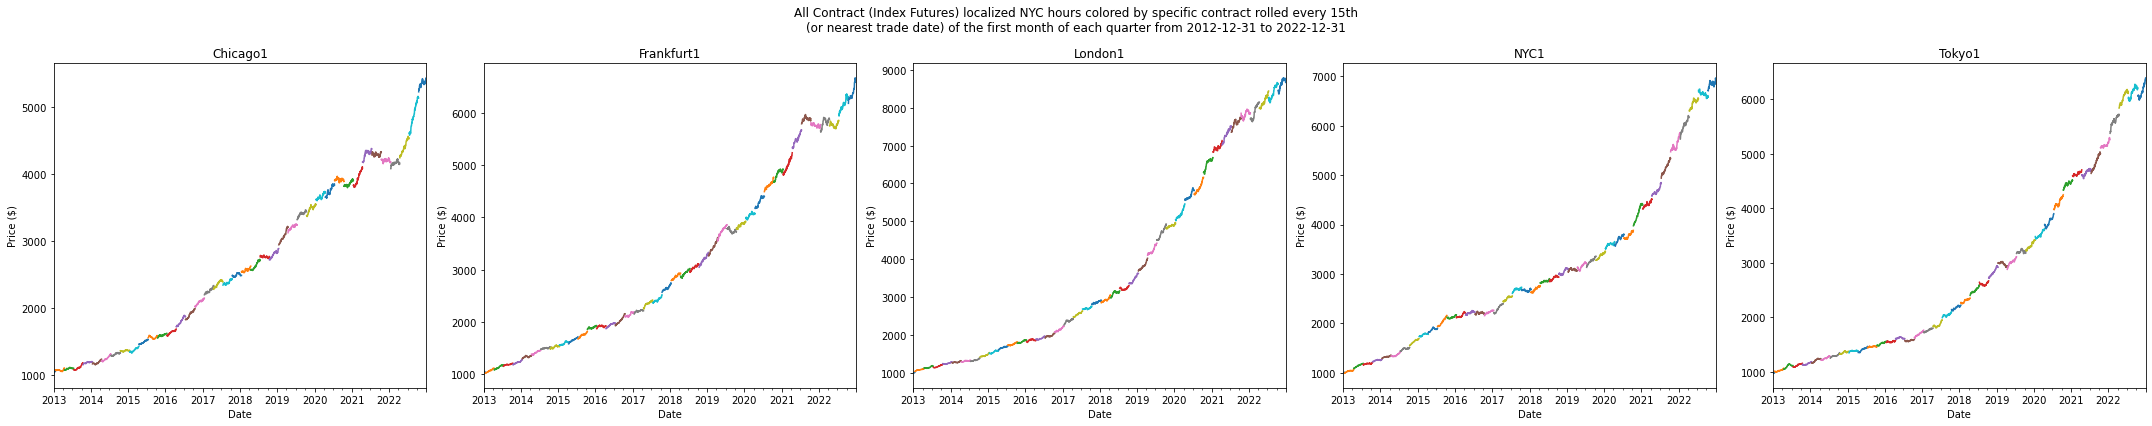

In [7]:
def plot_close_with_roll(df_price: pd.DataFrame):

    contract_names = df_price.contract_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(contract_names), figsize = (30,6))

    for i, contract_name in enumerate(contract_names):

        df_tmp = (df_price.query(
            "contract_name == @contract_name").
            set_index("nyc_time").
            resample("D").
            first())

        contracts = df_tmp.contract.drop_duplicates().to_list()
        for contract in contracts:

            (df_tmp.query(
                "contract == @contract")
                [["close_price"]].
                plot(
                    ax = axes[i],
                    legend = False,
                    title = "{}".format(contract_name),
                    xlabel = "Date",
                    ylabel = "Price ($)"))

    fig.suptitle("All Contract (Index Futures) localized NYC hours colored by specific contract rolled every 15th\n(or nearest trade date) of the first month of each quarter from {} to {}".format(
        df_price.nyc_time.min().date(),
        df_price.nyc_time.max().date()))
    plt.tight_layout()
    plt.show()

plot_close_with_roll(df_price)

In [8]:
asdf

NameError: name 'asdf' is not defined

Plot sample close. This will be done by picking a random nyc monday and plotting the returns for those days

In [9]:
rand_date = (df_price.assign(
    date = lambda x: pd.to_datetime(x.nyc_time.dt.strftime("%Y-%m-%d")))
    [["contract_name", "date"]].
    groupby(["contract_name"]).
    head(1).
    sample(frac = 1, random_state = 123).
    head(1).
    date.
    iloc[0].
    date())

In [ ]:
asdfasdf

In [ ]:
(df_price.assign(contract = lambda x: x.contract.str.split("_").str[1].astype(int)).query("contract == 1"))

In [19]:
a = df_price.assign(date = lambda x: pd.to_datetime(x.nyc_time.dt.strftime("%Y-%m-%d"))).query("date == '2018-05-08'")

array([<AxesSubplot:xlabel='nyc_time'>, <AxesSubplot:xlabel='nyc_time'>,
       <AxesSubplot:xlabel='nyc_time'>, <AxesSubplot:xlabel='nyc_time'>,
       <AxesSubplot:xlabel='nyc_time'>], dtype=object)

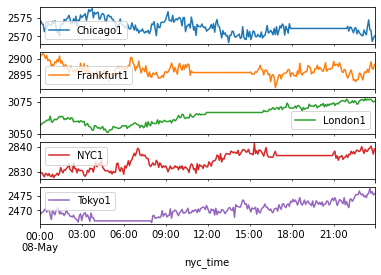

In [24]:
a[["contract_name", "close_price", "nyc_time"]].pivot(index = "nyc_time", columns = "contract_name", values = "close_price").plot(subplots = True)

Make bars

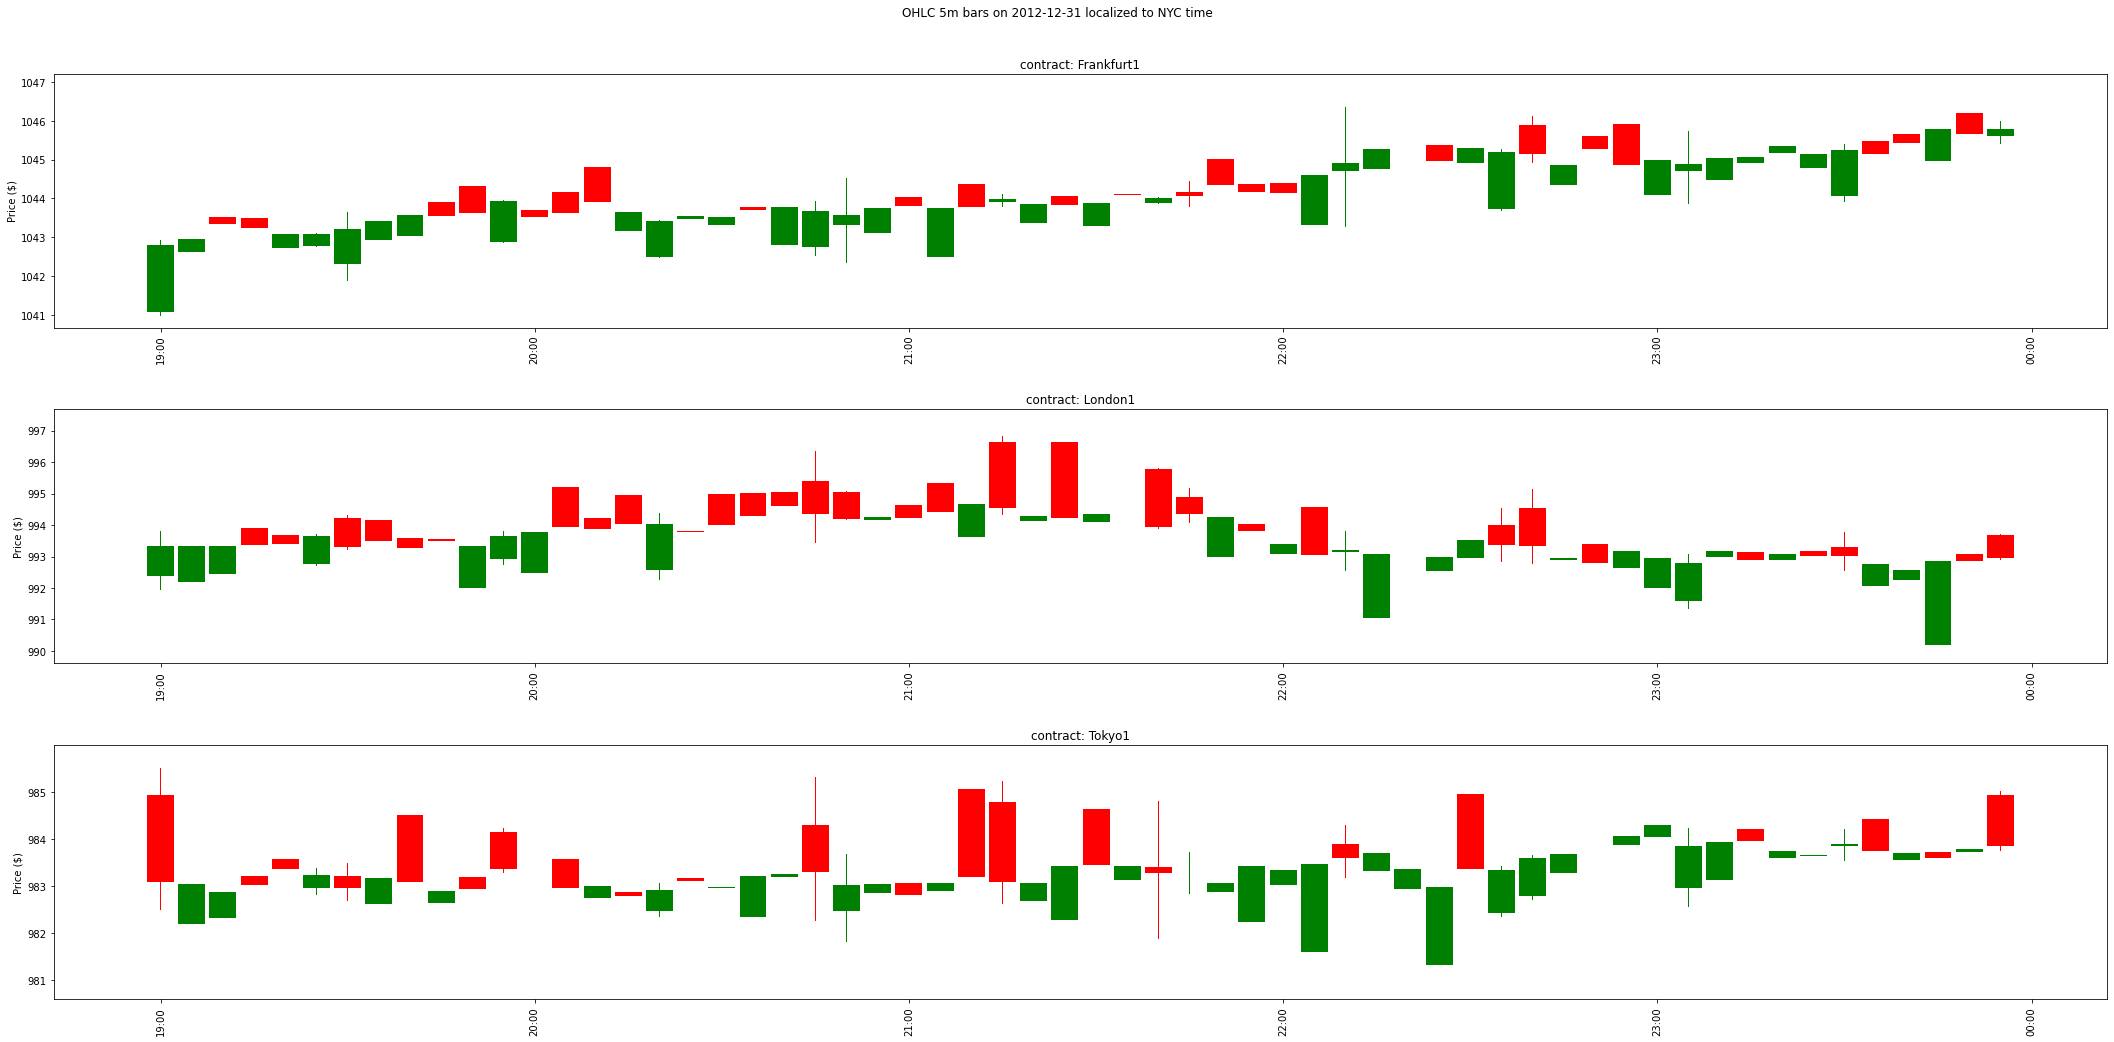

In [11]:
def make_ohlc_bars(df_price: pd.DataFrame, rand_date):

    df_tmp = (df_price.assign(
        date = lambda x: pd.to_datetime(x.nyc_time.dt.strftime("%Y-%m-%d"))).
        query("date == @rand_date"))

    df_contract = (df_tmp.set_index(
        "nyc_time")
        [["contract_name", "open_price", "high_price", "low_price", "close_price"]])

    contracts = df_contract.contract_name.drop_duplicates().to_list()

    fig, axes = plt.subplots(nrows = len(contracts), figsize = (30,15))
    for i, contract in enumerate(contracts):

        df_plot = (df_contract.query(
            "contract_name == @contract").
            drop(columns = ["contract_name"]))

        df_up = df_plot.query("close_price > open_price")
        df_down = df_plot.query("close_price < open_price")

        width1 = 0.003
        width2 = 0.00003

        axes[i].bar(df_up.index, df_up.close_price - df_up.open_price, width1, bottom = df_up.open_price, color = "red")
        axes[i].bar(df_up.index, df_up.high_price - df_up.close_price, width2, bottom = df_up.close_price, color = "red") 
        axes[i].bar(df_up.index, df_up.low_price - df_up.open_price, width2, bottom = df_up.open_price, color = "red") 

        axes[i].bar(df_down.index, df_down.close_price - df_down.open_price, width1, bottom = df_down.open_price, color = "green")
        axes[i].bar(df_down.index, df_down.high_price - df_down.open_price, width2, bottom = df_down.open_price, color = "green") 
        axes[i].bar(df_down.index, df_down.low_price - df_down.close_price, width2, bottom = df_down.close_price, color = "green") 

        axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        axes[i].tick_params(axis = "x", rotation = 90)
        axes[i].set_title("contract: {}".format(contract))
        axes[i].set_ylabel("Price ($)")

    fig.suptitle("OHLC 5m bars on {} localized to NYC time".format(rand_date))
    plt.tight_layout(pad = 3)

make_ohlc_bars(df_price, rand_date)

# Calculations

## Rolling Adjusted Close

In [25]:
def _get_first_last(df: pd.DataFrame) -> pd.DataFrame: 
    return(df.query(
        "local_time == local_time.min() | local_time == local_time.max()").
        assign(
            place = ["first", "last"],
            contract = lambda x: x.contract.astype(int)))

def _calc_roll_cost(df: pd.DataFrame) -> pd.DataFrame:
    
    cost = df.close_price.diff().to_list()[1]
    date = df.local_time.max()
    df_out = (pd.DataFrame({
        "cost": [cost],
        "local_time": [date]}))
    
    return df_out

def _get_roll_cost(df: pd.DataFrame) -> pd.DataFrame:
    
    # get first and last price of each contract
    df_first_last = (df.assign(
        contract = lambda x: x.contract.str.split("_").str[1]).
        groupby(["contract"]).
        apply(_get_first_last).
        reset_index(drop = True).
        sort_values("contract"))
    
    # then drop the first value of the first contract since it wasn't rolled into
    first_contract = df_first_last.contract.min()
    df_first_last_shifted = (df_first_last.query(
        "contract != contract.min() | place != 'first'").
        sort_values("local_time"))
    
    last_spot = df_first_last_shifted.query("contract == contract.max()").tail(1).place.iloc[0]
    
    # we can slice out the last spot if it isn't rolled into
    if last_spot == "last": df_first_last_shifted = df_first_last_shifted.iloc[:-1]
    
    df_grouped = (df_first_last_shifted.assign(
        group = np.repeat(range(1, int(len(df_first_last_shifted) / 2) + 1), 2)).
        groupby(["group"]).
        apply(_calc_roll_cost).
        set_index("local_time").
        assign(cum_cost = lambda x: np.cumsum(x.cost)))

    return df_grouped

def get_roll_cost(df_price: pd.DataFrame) -> pd.DataFrame:

    df_out = (df_price[
        ["local_time", "contract", "close_price", "contract_name"]].
        groupby("contract_name").
        apply(_get_roll_cost).
        reset_index())
    
    return df_out

def plot_roll_cost(df_price: pd.DataFrame, figsize: tuple = (30, 6)) -> pd.DataFrame:
    
    df_roll_cost = get_roll_cost(df_price)
    contract_names = df_roll_cost.contract_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(contract_name), nrows = 2, figsize = figsize)
    
    for i, contract_name in enumerate(contract_names):
        
        df_tmp = (df_roll_cost.query(
            "contract_name == @contract_name").
            drop(columns = ["contract_name"]).
            set_index("local_time"))
        
        df_tmp["cost"].plot(
            ax = axes[i,0])
        
        (df_tmp["cum_cost"].plot(
            ax = axes[i,1]))

In [28]:
get_roll_cost(df_price)

,contract_name,local_time,cost,cum_cost
0,Chicago1,2013-01-15 00:00:00,22.731778,22.731778
1,Chicago1,2013-04-15 00:00:00,-21.338807,1.392971
2,Chicago1,2013-07-15 00:00:00,-21.468336,-20.075365
3,Chicago1,2013-10-15 00:00:00,-24.808864,-44.884229
4,Chicago1,2014-01-15 00:00:00,-25.460263,-70.344493
...,...,...,...,...
191,Tokyo1,2021-10-14 23:55:00,365.591645,3640.650488
192,Tokyo1,2022-01-16 23:55:00,153.665417,3794.315905
193,Tokyo1,2022-04-14 23:55:00,358.803280,4153.119185
194,Tokyo1,2022-07-14 23:55:00,301.100743,4454.219928
